เคสก่อน ๆ เราได้นำ Deep Neural Networks มาประยุกต์ใช้กับงาน รูปภาพ Vision, ข้อความ NLP ได้ผลลัพธ์ออกมาน่าพอใจ แต่ในเคสนี้เราจะนำ Deep Neural Networks มาประยุกต์ใช้กับงานที่เรียกได้ว่าใกล้เคียงกับงานที่เราทำประจำวันมากที่สุด ก็คือ ข้อมูลแบบตาราง 

ไม่ว่าจะเป็น Excel, Relational Database, SQL, CSV เราก็สามารถนำ Deep Neural Networks มาประยุกต์ใช้ได้ และในบางโปรแกรมก็เริ่มมี Feature นี้มาให้ในตัวแล้ว เช่น ML.PREDICT จาก GCP Bigquery

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.tabular import *

# 2. ข้อมูล

เคสนี้เราจะใช้ Dataset ตารางรายได้สำมะโมประชากร Census Income จาก [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult)

เราจะให้โมเดลทำนายว่ารายได้ของบุคคล จะสูงหรือต่ำกว่า 50,000 USD ต่อปี จากข้อมูลประกอบต่าง ๆ เช่น การศึกษา อาชีพ สถานะสมรส เพศ สีผิว เชื้อขาติ etc.

* คุณลักษณะ Dataset:  หลายตัวแปร
* จำนวนข้อมูล: 48,842 Record
* สาขา: สังคม
* รูปแบบข้อมูล: หมวดหมู่ Categorical, ตัวเลข Integer
* จำนวน Column: 14
* วันที่ 1996-05-01
* งานที่เกี่ยวข้อง: Classification
* มีข้อมูลไม่ครบ? Yes

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/adult_sample')

ls ดูว่ามีไฟล์อะไรบ้าง

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/adult_sample/export.pkl'),
 PosixPath('/home/jupyter/.fastai/data/adult_sample/adult.csv'),
 PosixPath('/home/jupyter/.fastai/data/adult_sample/models')]

โหลดไฟล์ adult.csv ขึ้นมาดู

In [5]:
dataframe = pd.read_csv(path/'adult.csv')

เปิดดู 5 แถวแรก

In [6]:
dataframe.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


ดูสถิติของข้อมูล สังเกต

1. count แต่ละ Column ไม่เท่ากัน แสดงว่ามีข้อมูลขาดไป
2. unique คือ จำนวนหมวดหมู่ของข้อมูลแบบ Category แต่ละ Column
3. top, freq คือ ค่าและจำนวนครั้ง ของข้อมูลที่ปรากฎบ่อยที่สุด
4. mean, std, min, ... max ข้อมูลสถิติ ของข้อมูลตัวเลข

In [7]:
dataframe.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
count,32561.000000,32561,3.256100e+04,32561,32074.000000,32561,32049,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<50k
freq,NaN,22696,NaN,10501,NaN,14976,4073,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.079815,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572999,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


# 3. เตรียมข้อมูล



เราต้องบอก Databunch ว่า Column ไหนเป็นข้อมูลชนิดอะไร

1. dependent_variable คือ ข้อมูลที่เราจะทำนาย
2. category_column_names คือ Column ข้อมูลแบบหมวดหมู่ ไม่ต่อเนื่อง มีจำนวนเป็นไปได้จำกัด
3. continuous_column_names คือ Column ข้อมูลตัวเลข แบบค่าต่อเนื่อง มีจำนวนเป็นไปได้ไม่จำกัด
4. preprocesses คือ เราจะเตรียมข้อมูลอย่างไร ก่อนป้อนให้โมเดล เช่น FillMissing ใส่ค่าที่ขาดไป, Categorify สร้าง Embedding สำหรับข้อมูล Category, Normailze สำหรับข้อมูลตัวเลข

*เรื่อง Normalize, Embedding เราจะอธิบายต่อไป*

In [8]:
dependent_variable = 'salary'
category_column_names = ['workclass', 'education', 
                         'marital-status', 'occupation', 
                         'relationship', 'race']
continuous_column_names = ['age', 'fnlwgt', 'education-num']

preprocesses = [FillMissing, Categorify, Normalize]

แบ่งข้อมูล Record ที่ 800-1000 เอาไว้เป็น Validation Set

In [9]:
tabularlist_test = TabularList.from_df(dataframe.iloc[800:1000].copy(), 
                           path=path, 
                           cat_names=category_column_names, 
                           cont_names=continuous_column_names, 
                           procs=preprocesses)

สร้าง Databunch จากการกำหนดค่าด้านบน

In [10]:
databunch = (TabularList.from_df(dataframe, path=path, 
                                 cat_names=category_column_names, 
                                 cont_names=continuous_column_names, 
                                 procs=preprocesses)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dependent_variable)
                           .add_test(tabularlist_test)
                           .databunch())

## สำรวจข้อมูล ##


*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [11]:
databunch.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
Private,Some-college,Never-married,Exec-managerial,Own-child,White,False,-1.4357,-1.4029,-0.0312,<50k
Private,Some-college,Divorced,Exec-managerial,Not-in-family,White,False,0.5434,0.5833,-0.0312,<50k
Private,11th,Married-civ-spouse,Sales,Husband,White,False,1.4229,-0.3983,-1.2046,<50k
?,Some-college,Never-married,?,Own-child,White,False,-1.3624,-0.1423,-0.0312,<50k
Private,10th,Married-spouse-absent,Protective-serv,Not-in-family,Asian-Pac-Islander,False,1.4962,-0.4868,-1.5958,<50k
Local-gov,Doctorate,Married-civ-spouse,Exec-managerial,Husband,White,False,1.1297,-1.4685,2.3157,>=50k
Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,False,-0.8493,0.1757,-0.4224,<50k
Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,1.3496,0.0968,1.1422,>=50k
Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,2.0093,1.5243,-0.0312,<50k
Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,-0.1896,0.1081,1.1422,<50k


สังเกตตัวเลข อายุมีค่าเป็นติดลบ เนื่องจากการ Normailze จะทำให้ Mean = 0, Standard Deviation = 1 และ มี Column ใหม่ คื education-num_na ขึ้นมาเพื่อบอกว่า มีการเติมค่าที่หายไปให้กับ Record นี้

In [12]:
databunch.classes

['<50k', '>=50k']

# 4. สร้างโมเดล

เนื่องจากตารางเล็ก ๆ ไม่ซับซ้อน เราจะสร้างโมเดล ที่ประกอบด้วย Dense Layer ที่ Deep แค่ 2 Hidden Layer โดยที่เหลือใช้ค่า Default ทั้งหมด เรื่องชนิดของ Layer เช่น Dense ไว้เราจะอธิบายต่อไป

In [13]:
learner = tabular_learner(databunch, layers=[256, 128], 
                          metrics=accuracy, 
                          callback_fns=ShowGraph)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 1 Cycle สามารถใช้ Learning Rate สูง ๆ ได้เลย

epoch,train_loss,valid_loss,accuracy,time
0,0.351273,0.378220,0.840000,00:03


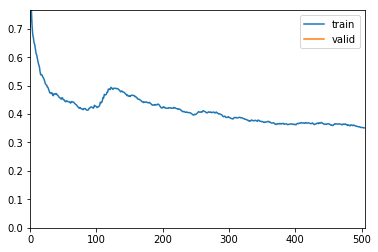

In [14]:
learner.fit_one_cycle(1, 2e-1)

## สำเร็จแล้ว ##

เพียงแค่เวลา 3 วินาที เราเทรน Model ได้ accuracy ประมาณ 0.84 หรือ ความแม่นยำประมาณ 84%


In [15]:
learner.save("05a-tabular")

In [16]:
learner.load("05a-tabular");

# 6. ดูผลลัพธ์

ลองดูข้อมูล Record ที่ 850

In [19]:
row = dataframe.iloc[850]
row

age                           30
workclass              Local-gov
fnlwgt                    352542
education              Bachelors
education-num                 13
marital-status          Divorced
occupation                   NaN
relationship           Unmarried
race                       White
sex                       Female
capital-gain                   0
capital-loss                   0
hours-per-week                40
native-country     United-States
salary                      <50k
Name: 850, dtype: object

ให้โมเดลทำนายกัน

In [20]:
learner.predict(row)


(Category <50k, tensor(0), tensor([0.9325, 0.0675]))

โมเดลทำนายได้ถูกต้อง

# 7. สรุป

1. การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน แต่สำหรับข้อมูลแบบตาราง จะมีประเด็นด้านข้อมูลไม่สมบูรณ์ กรอกไม่ครบ ข้อมูลขาดหาย และเนื่องจากโมเดลรับได้แต่ตัวเลข จึงจำเป็นต้องมีการทำ Preprocessing เตรียมข้อมูลก่อนเทรน
2. เราสามารถสร้าง โมเดล Classification จากข้อมูลแบบตารางได้ไม่ยาก ใช้เวลาเทรนไม่นาน ไม่จำเป็นต้องใช้ GPU
3. โมเดลแบบนี้ สามารถนำไปประยุกต์ใช้ในระบบงานออฟฟิศทั่วไป ได้อย่างหลากหลาย เพราะข้อมูลในภาคธุรกิจส่วนใหญ่ก็จะอยู่ในรูปแบบตารางแบบนี้อยู่แล้ว

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 4](https://course.fast.ai/videos/?lesson=4)
* [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult)